In [6]:
suppressPackageStartupMessages(require("DESeq2"))
library(tidyverse)
library('biomaRt')
library('genefilter')
library('RColorBrewer')
library('gplots')

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
collapse(): dplyr, IRanges
combine():  dplyr, Biobase, BiocGenerics
count():    dplyr, matrixStats
desc():     dplyr, IRanges
expand():   tidyr, S4Vectors
filter():   dplyr, stats
first():    dplyr, S4Vectors
lag():      dplyr, stats
Position(): ggplot2, BiocGenerics, base
reduce():   purrr, GenomicRanges, IRanges
rename():   dplyr, S4Vectors
select():   dplyr, biomaRt
slice():    dplyr, IRanges
spec():     readr, genefilter


In [7]:
sampleName = grep('.htseqcount.txt', list.files('.'), value=TRUE)

In [8]:
sampleType = gsub('_[0-9]+.htseqcount.txt', '', sampleName)

In [9]:
sampleTable = data.frame(sampleName = sampleName, fileName = sampleName, sampleType = sampleType)


In [10]:
ddsHTSeq <- DESeqDataSetFromHTSeqCount(sampleTable = sampleTable, directory = '.', design = ~sampleType) 

# Prepare Ensemble to Gene Name using biomaRt
ensembl = useMart('ensembl', dataset="hsapiens_gene_ensembl")
bm = getBM(attributes=c('ensembl_gene_id', 'external_gene_name', 'description'), filter='ensembl_gene_id', values=rownames(ddsHTSeq), mart=ensembl)
bm = arrange(bm, ensembl_gene_id)

# Now use this data to annotate ensembl GeneID to external gene name as row meta data
DESeq2Features = data.frame(ensembl_gene_id = rownames(ddsHTSeq))
DESeq2Features$ensembl_gene_id = as.character(DESeq2Features$ensembl_gene_id)
rowData = dplyr::left_join(DESeq2Features, bm, by='ensembl_gene_id')
rowData = as(rowData, 'DataFrame')
mcols(rowData(ddsHTSeq)) = c(mcols(rowData(ddsHTSeq)), rowData)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

In [12]:
dds = DESeq(ddsHTSeq)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [13]:
resultsNames(dds)

[1] "Intercept"                "sampleType_MAT_vs_BEM"   
[3] "sampleType_NSC_vs_BEM"    "sampleType_Tissue_vs_BEM"

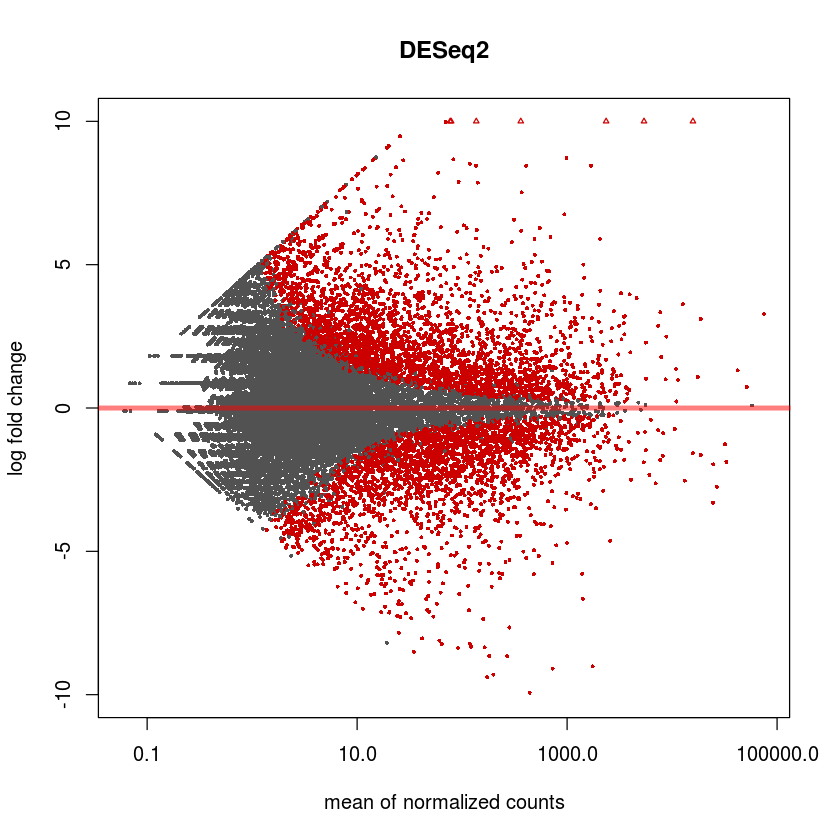

In [14]:
plotMA(dds, ylim=c(-10,10), main="DESeq2")

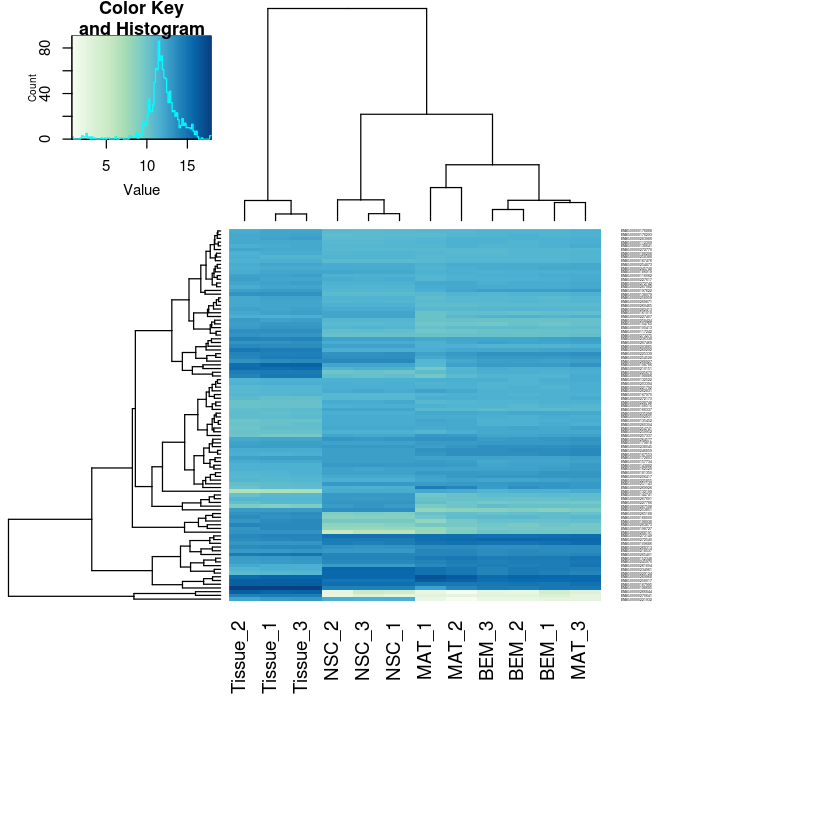

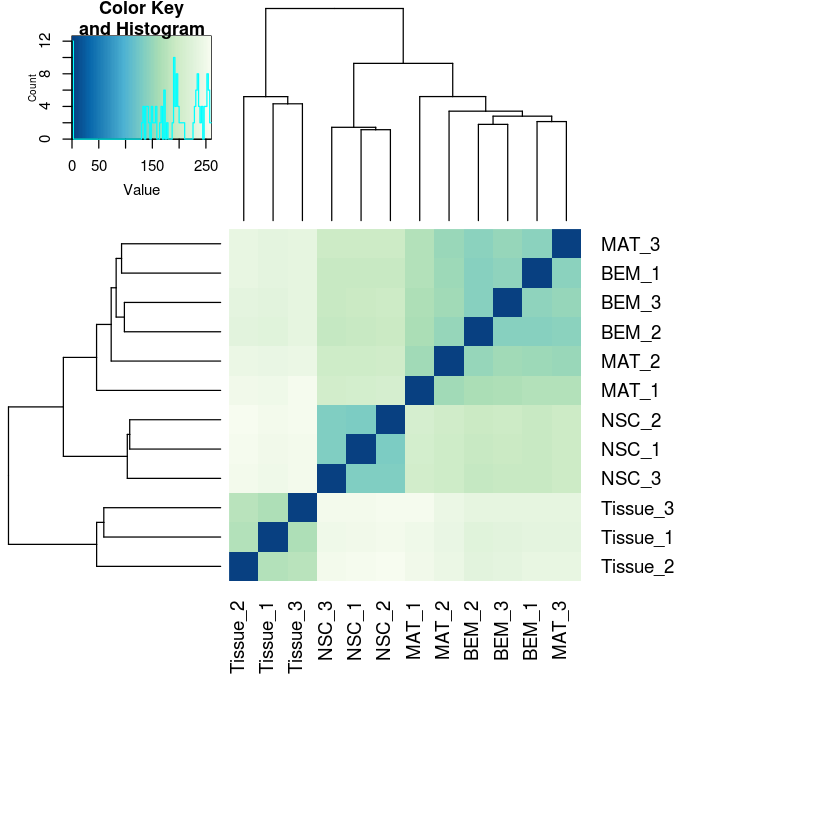

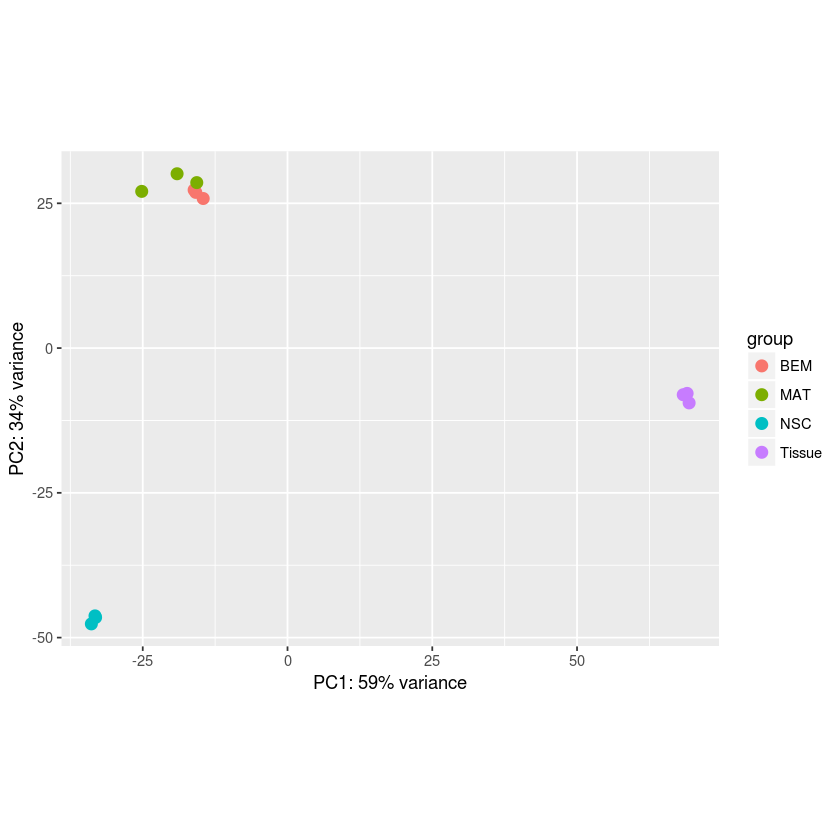

In [15]:
vsd = varianceStabilizingTransformation(dds, blind=TRUE)


select = order(rowMeans(counts(dds, normalized=TRUE)), decreasing=TRUE)[1:100]
hmcol = colorRampPalette(brewer.pal(9, 'GnBu'))(100)

diff_exp_genes = assay(vsd)[select,]
colnames(diff_exp_genes) = gsub('.htseqcount.txt', '', colnames(diff_exp_genes))
heatmap.2(diff_exp_genes, dendrogram = 'both', col=hmcol, scale='none', trace='none', margin=c(12,12), cexRow=0.2)

distsvsd = dist(t(assay(vsd)))

mat = as.matrix(distsvsd)
colnames(mat) = gsub('.htseqcount.txt', '', colnames(mat))
rownames(mat) = gsub('.htseqcount.txt', '', rownames(mat))

heatmap.2(mat, trace='none', col=rev(hmcol), margin=c(13,13))

plotPCA(vsd, intgroup=c('sampleType'))

In [16]:
head(rowMeans(counts(dds, normalized=TRUE)))

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
     0.69262344      0.06295539      7.91694920    168.33689259    190.66778832 
ENSG00000000938 
     1.65312316

In [17]:
sampleTable 

sampleName,fileName,sampleType
BEM_1.htseqcount.txt,BEM_1.htseqcount.txt,BEM
BEM_2.htseqcount.txt,BEM_2.htseqcount.txt,BEM
BEM_3.htseqcount.txt,BEM_3.htseqcount.txt,BEM
MAT_1.htseqcount.txt,MAT_1.htseqcount.txt,MAT
MAT_2.htseqcount.txt,MAT_2.htseqcount.txt,MAT
MAT_3.htseqcount.txt,MAT_3.htseqcount.txt,MAT
NSC_1.htseqcount.txt,NSC_1.htseqcount.txt,NSC
NSC_2.htseqcount.txt,NSC_2.htseqcount.txt,NSC
NSC_3.htseqcount.txt,NSC_3.htseqcount.txt,NSC
Tissue_1.htseqcount.txt,Tissue_1.htseqcount.txt,Tissue


In [18]:
library('org.Hs.eg.db')
resTB = results(dds, contrast=c("sampleType","Tissue","BEM"))
resMB = results(dds, contrast=c("sampleType","MAT","BEM"))
resNB = results(dds, contrast=c("sampleType","NSC","BEM"))

resTM = results(dds, contrast=c("sampleType","Tissue","MAT"))
resNM = results(dds, contrast=c("sampleType","NSC","MAT"))
resTN = results(dds, contrast=c("sampleType","Tissue","NSC"))

Loading required package: AnnotationDbi

Attaching package: ‘AnnotationDbi’

The following object is masked from ‘package:dplyr’:

    select




In [19]:

resTB$hgnc_symbol <- unname(mapIds(org.Hs.eg.db, rownames(resTB), "SYMBOL", "ENSEMBL"))
resMB$hgnc_symbol <- unname(mapIds(org.Hs.eg.db, rownames(resMB), "SYMBOL", "ENSEMBL"))
resNB$hgnc_symbol <- unname(mapIds(org.Hs.eg.db, rownames(resNB), "SYMBOL", "ENSEMBL"))
resTM$hgnc_symbol <- unname(mapIds(org.Hs.eg.db, rownames(resTM), "SYMBOL", "ENSEMBL"))
resNM$hgnc_symbol <- unname(mapIds(org.Hs.eg.db, rownames(resNM), "SYMBOL", "ENSEMBL"))
resTN$hgnc_symbol <- unname(mapIds(org.Hs.eg.db, rownames(resTN), "SYMBOL", "ENSEMBL"))


'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns


In [60]:
resTB_ordered = resTB[order(resTB$padj, decreasing = TRUE),]
dim(resTB_ordered[which(resTB_ordered$padj<0.01), ])

resMB_ordered = resMB[order(resMB$padj, decreasing = TRUE),]
dim(resMB_ordered[which(resMB_ordered$padj<0.01), ])

resNB_ordered = resNB[order(resNB$padj, decreasing = TRUE),]
dim(resNB_ordered[which(resNB_ordered$padj<0.01), ])

resTM_ordered = resTM[order(resTM$padj, decreasing = TRUE),]
dim(resTM_ordered[which(resTM_ordered$padj<0.01), ])

resNM_ordered = resNM[order(resNM$padj, decreasing = TRUE),]
dim(resNM_ordered[which(resNM_ordered$padj<0.01), ])

resTN_ordered = resTN[order(resTN$padj, decreasing = TRUE),]
dim(resTN_ordered[which(resTN_ordered$padj<0.01), ])



[1] 3898    7

[1] 162   7

[1] 2388    7

[1] 3926    7

[1] 2399    7

[1] 4484    6

In [ ]:
resTB_ordered

In [64]:
as.tibble(DESeqResults(resMB)) %>% filter(hgnc_symbol %in% c('CALB2', 'OCT4','TBR2', 'TBR1', 'EMX1', 'SOX17', 'FOXG1', 'KLF4', 'EN2', 'GBX2', 'OTX2', 'EN2', 'OTX2', 'FOXA2', 'DCX', 'FOXG1', 'PAX6', 'MAP2', 'ANK2', 'NCAM', 'DLX1', 'DLX5', 'DLX6', 'ERBB4', 'SATB1', 'SCN1A', 'LHX6', 'SOX2'))

Warning message in as.data.frame(x, row.names = NULL, optional = optional, ...):
“Arguments in '...' ignored”

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,hgnc_symbol
6.0143644,-5.55153434,1.3872095,-4.00194363,0.00006282427,NA,DLX6
259.9641284,-0.21747064,0.1832433,-1.18678655,0.23531182459,0.6013330,PAX6
4.8154331,-0.82267172,0.8375082,-0.98228492,0.32595949965,NA,DCX
19.0647894,0.19389593,0.5425781,0.35736041,0.72082200766,0.9134662,MAP2
0.5703028,1.26912127,3.1532564,0.40247957,0.68733112138,NA,DLX5
1.7778366,2.18577686,1.8967804,1.15236160,0.24917251314,NA,LHX6
0.6347114,2.72638497,3.4846065,0.78240827,0.43397467738,NA,FOXA2
16.7975720,-0.57653610,0.5679945,-1.01503820,0.31008761793,0.6708090,EMX1
4.0993439,-0.98749144,0.8474459,-1.16525607,0.24391535586,NA,TBR1
1.1437425,0.74456215,1.8545504,0.40147851,0.68806785597,NA,KLF4


In [ ]:
resMB

In [42]:
resTN = results(dds, contrast=c("sampleType","Tissue","NSC"), alpha=0.01)

In [43]:
sum(resTN$pvalue < 0.01, na.rm=TRUE)

[1] 5272

In [44]:
sum(resTB$pvalue < 0.01, na.rm=TRUE)

[1] 4679

In [45]:
sum(resTM$pvalue < 0.01, na.rm=TRUE)

[1] 4736

In [46]:
table(resTM[, 'padj'] < 0.01)


FALSE  TRUE 
13142  3926 

In [47]:
table(resTN[, 'padj'] < 0.01)


FALSE  TRUE 
10735  4484 

In [48]:
table(resTB[, 'padj'] < 0.01)


FALSE  TRUE 
13170  3898 

In [49]:
table(resMB[, 'padj'] < 0.01)


FALSE  TRUE 
 6429   162 

In [50]:
table(resTM[, 'padj'] < 0.01)


FALSE  TRUE 
13142  3926 

In [51]:
table(resNM[, 'padj'] < 0.01)


FALSE  TRUE 
14053  2399 

In [52]:
table(resTN[, 'padj'] < 0.01)


FALSE  TRUE 
10735  4484 

In [53]:
table(resNB[, 'padj'] < 0.01)


FALSE  TRUE 
13447  2388 

In [54]:
dim(resTN)

[1] 57905     6

In [58]:
overallBaseMean = as.matrix(resNB[, 'baseMean', drop=F])
sigGenes = rownames(subset(resNB, padj<0.01))
anno = mcols(rowData(ddsHTSeq))[,1:3]
anSig = subset(anno, ensemble_gene_id %in% sigGenes)


ERROR: Error: subscript is a logical vector with out-of-bounds TRUE values


In [ ]:
backG = genefinder(overallBaseMean, anSig$ensembl_gene_id, 10, method='manhattan')

In [59]:
sigGenes

[1] "ENSG00000000457" "ENSG00000003509" "ENSG00000004142" "ENSG00000005187"
  [5] "ENSG00000005812" "ENSG00000005882" "ENSG00000005893" "ENSG00000006015"
  [9] "ENSG00000006062" "ENSG00000006453" "ENSG00000006468" "ENSG00000006740"
 [13] "ENSG00000007402" "ENSG00000007520" "ENSG00000008083" "ENSG00000008130"
 [17] "ENSG00000008226" "ENSG00000011028" "ENSG00000011304" "ENSG00000011485"
 [21] "ENSG00000012232" "ENSG00000013297" "ENSG00000013563" "ENSG00000016391"
 [25] "ENSG00000016864" "ENSG00000018625" "ENSG00000020181" "ENSG00000025434"
 [29] "ENSG00000026025" "ENSG00000032444" "ENSG00000040199" "ENSG00000041982"
 [33] "ENSG00000042317" "ENSG00000044115" "ENSG00000047315" "ENSG00000048052"
 [37] "ENSG00000048162" "ENSG00000049247" "ENSG00000050130" "ENSG00000050344"
 [41] "ENSG00000050767" "ENSG00000053918" "ENSG00000055332" "ENSG00000056972"
 [45] "ENSG00000058453" "ENSG00000059145" "ENSG00000062038" "ENSG00000063046"
 [49] "ENSG00000063176" "ENSG00000064012" "ENSG00000064201" "ENSG00000064490"
 [53] "ENSG00000064601" "ENSG00000064999" "ENSG00000065183" "ENSG00000065427"
 [57] "ENSG00000065675" "ENSG00000065911" "ENSG00000066185" "ENSG00000066422"
 [61] "ENSG00000066855" "ENSG00000067369" "ENSG00000067560" "ENSG00000067596"
 [65] "ENSG00000067646" "ENSG00000068793" "ENSG00000070010" "ENSG00000070540"
 [69] "ENSG00000071462" "ENSG00000072071" "ENSG00000072134" "ENSG00000072163"
 [73] "ENSG00000072195" "ENSG00000072210" "ENSG00000072415" "ENSG00000072657"
 [77] "ENSG00000072818" "ENSG00000072832" "ENSG00000072840" "ENSG00000072858"
 [81] "ENSG00000073111" "ENSG00000073331" "ENSG00000074276" "ENSG00000074410"
 [85] "ENSG00000075399" "ENSG00000075539" "ENSG00000075826" "ENSG00000076053"
 [89] "ENSG00000076351" "ENSG00000076513" "ENSG00000077157" "ENSG00000077616"
 [93] "ENSG00000078061" "ENSG00000078487" "ENSG00000079101" "ENSG00000079215"
 [97] "ENSG00000079805" "ENSG00000080644" "ENSG00000080845" "ENSG00000081377"
 [ reached getOption("max.print") -- omitted 2288 entries ]

In [67]:
# LIST Of genes that are significantly differentially expressed between MATRIGEL and BEM
as.tibble(resMB[which(resMB[, 'padj'] < 0.01), ]) %>% arrange(desc(padj))

Warning message in as.data.frame(x, row.names = NULL, optional = optional, ...):
“Arguments in '...' ignored”

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,hgnc_symbol
165.45938,-1.1875570,0.32366501,-3.669093,0.0002434126,0.009903286,NA
1111.69301,0.3645233,0.09919660,3.674756,0.0002380766,0.009746355,NA
42.09514,2.0461701,0.55398843,3.693525,0.0002211667,0.009110687,NA
7387.19406,0.3534513,0.09545571,3.702778,0.0002132517,0.008839885,NA
197.04847,0.9944220,0.26813809,3.708619,0.0002083928,0.008693145,NA
35.73077,2.2040270,0.59334688,3.714567,0.0002035516,0.008545277,PDIA6
12.73405,5.1538817,1.38551269,3.719837,0.0001993512,0.008422588,NA
24.66800,2.6568340,0.71260057,3.728364,0.0001927272,0.008195258,NA
95.98916,-0.9856471,0.26401013,-3.733369,0.0001889357,0.008086203,NEIL1
107.12103,0.8905722,0.23852710,3.733631,0.0001887390,0.008086203,NA
